# 多图生成测试

In [1]:
import numpy as np
import rp
import torch
import torch.nn as nn
import source.stable_diffusion as sd
from easydict import EasyDict
from source.learnable_textures import LearnableImageFourier
from source.stable_diffusion_labels import NegativeLabel
from itertools import chain
import time

/home/llt/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#ONLY GOOD PROMPTS HERE
example_prompts = rp.load_yaml_file('source/easy_prompts.yaml')
print('Available example prompts:', ', '.join(example_prompts))

Available example prompts: colorful_sunset, abstract_shapes, futuristic_city, dense_forest, stormy_ocean, magical_castle, desert_landscape, starry_night, floating_island, vibrant_market, snowy_mountain, glowing_nebula, peaceful_lake, fiery_dragon, robotic_creature, blooming_garden, chaotic_explosion, serene_waterfall, mysterious_portal, glowing_crystal


In [3]:
if 's' not in dir():
    model_name="./stable-diffusion-v1-4"
    gpu='cuda:0'
    s=sd.StableDiffusion(gpu,model_name)
device=s.device

[INFO] sd.py: loading stable diffusion...please make sure you have run `huggingface-cli login`.


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 10.52it/s]


[INFO] sd.py: loaded stable diffusion!


In [4]:
from PIL import Image
import torch
from torchvision import transforms

# 1. 从文件中读取图像
image_path = "your_image.png"  # 替换为你的图像路径
image = Image.open(image_path)
if image.mode == 'RGBA':
    image = image.convert('RGB')  

# 2. 定义预处理步骤
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # 调整大小为 256x256
    transforms.ToTensor(),  # 转换为 PyTorch 张量
])

# 3. 对图像进行预处理
image_tensor = preprocess(image)

In [5]:
#Image Parametrization and Initialization (this section takes vram)

#Select Learnable Image Size (this has big VRAM implications!):
#Note: We use implicit neural representations for better image quality
#They're previously used in our paper "TRITON: Neural Neural Textures make Sim2Real Consistent" (see tritonpaper.github.io)
# ... and that representation is based on Fourier Feature Networks (see bmild.github.io/fourfeat)
learnable_image_maker = lambda: LearnableImageFourier(height=256, width=256, hidden_dim=256, num_features=128).to(s.device); SIZE=256
# learnable_image_maker = lambda: LearnableImageFourier(height=512,width=512,num_features=256,hidden_dim=256,scale=20).to(s.device);SIZE=512

image=learnable_image_maker()

In [6]:
learnable_image_a=lambda: image() #Right-side up



In [7]:
learnable_images=[learnable_image_a]

#The weight coefficients for each prompt. For example, if we have [0,1], then only the upside-down mode will be optimized
weights=[1,1]

weights=rp.as_numpy_array(weights)
weights=weights/weights.sum()
weights=weights*len(weights)

In [8]:
#For saving a timelapse
ims=[]

In [9]:
def get_display_image():
    return rp.tiled_images(
        [
            rp.as_numpy_image(learnable_image_a()),
        ],
        length=len(learnable_images),
        border_thickness=0,
    )

In [10]:
print(image_tensor.shape)

torch.Size([3, 256, 256])


In [11]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

model_name = "./clip-vit-base-patch32"
CLIP = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

image1 = learnable_image_a()
image2 = image_tensor
def tensor_to_pil(image_tensor):
    return transforms.ToPILImage()(image_tensor)
inputs2 = processor(images=tensor_to_pil(image2), return_tensors="pt", padding=True)

with torch.no_grad():
    features2 = CLIP.get_image_features(**inputs2)

features2 = features2 / features2.norm(dim=-1, keepdim=True)


In [12]:
import os
import torch
import torch.nn as nn
from os.path import expanduser  # pylint: disable=import-outside-toplevel
from urllib.request import urlretrieve  # pylint: disable=import-outside-toplevel
def get_aesthetic_model(clip_model="vit_l_14"):
    """load the aethetic model"""
    home = expanduser("~")
    cache_folder = home + "/.cache/emb_reader"
    path_to_model = cache_folder + "/sa_0_4_"+clip_model+"_linear.pth"
    if not os.path.exists(path_to_model):
        os.makedirs(cache_folder, exist_ok=True)
        url_model = (
            "https://github.com/LAION-AI/aesthetic-predictor/blob/main/sa_0_4_"+clip_model+"_linear.pth?raw=true"
        )
        urlretrieve(url_model, path_to_model)
    if clip_model == "vit_l_14":
        m = nn.Linear(768, 1)
    elif clip_model == "vit_b_32":
        m = nn.Linear(512, 1)
    else:
        raise ValueError()
    s = torch.load(path_to_model)
    m.load_state_dict(s)
    m.eval()
    return m

AVA = get_aesthetic_model(clip_model="vit_b_32")

/tmp/ipykernel_2529982/3948651879.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s = torch.load(path_to_model)


In [13]:
print(AVA(CLIP.get_image_features(**inputs2)))

tensor([[17.4638]], grad_fn=<AddmmBackward0>)


In [14]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 加载 DINOv2 模型
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
model.eval()

# 图片预处理
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



def VendiScore(images):
    features = []
    with torch.no_grad():
        for img in images:
            img = transform(img).unsqueeze(0)  # 预处理并添加 batch 维度
            feature = model(img)  # 提取特征
            features.append(feature.squeeze().numpy())
    features = np.array(features)  # 转换为 NumPy 数组

    # 计算相似性矩阵
    similarity_matrix = cosine_similarity(features)

    # 计算 Vendi Score
    eigenvalues = np.linalg.eigvalsh(similarity_matrix)
    epsilon = 1e-10  # 避免 log(0)
    eigenvalues = eigenvalues / np.sum(eigenvalues)  # 归一化
    entropy = -np.sum(eigenvalues * np.log(eigenvalues + epsilon))
    vendi_score = np.exp(entropy)
    return vendi_score

Using cache found in /home/llt/.cache/torch/hub/facebookresearch_dinov2_main
/home/llt/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/llt/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/llt/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [21]:
prompts = example_prompts.copy()
cosine_similarity_per_seed = []
ava_score_per_seed = []
vendi_score = []
randomseeds = [1,2,5,7,10,100,42,88,99,73]
negative_prompt = ''
NUM_ITER=300
for prompt in example_prompts:
    label_a = NegativeLabel([example_prompts[prompt]],negative_prompt)
    labels = [label_a]
    weights = [1]
    image_of_this_prompt = []
    for seed in randomseeds:
        print(f"prompt {prompt},seed {seed}")
        ims = []
        torch.manual_seed(seed)
        np.random.seed(seed)
        img = learnable_image_maker()
        optim=torch.optim.SGD(img.parameters(),lr=1e-4)
        img_a = img
        learnable_images = [img_a]
        try:
            for iter_num in range(NUM_ITER):
                preds=[]
                for label,learnable_image,weight in rp.random_batch(list(zip(labels,learnable_images,weights)), batch_size=1):
                    
                    pred=s.train_step(
                        label.embedding,
                        learnable_image()[None],
                        noise_coef=.1*weight,guidance_scale=60,target_image=image_tensor
                    )
                    preds+=list(pred)
                optim.step()
                optim.zero_grad()
                with torch.no_grad():
                    if iter_num == NUM_ITER - 1:
                        im = rp.as_numpy_image(learnable_image())
                        ims.append(im)
                
        except KeyboardInterrupt:
            print('Interrupted early at iteration %i'%iter_num)
            im = img_a()
            ims.append(im)
            #rp.display_image(im)
            raise KeyboardInterrupt
        inputs1 = processor(images=tensor_to_pil(ims[-1]), return_tensors="pt", padding=True)
        with torch.no_grad():
            features1 = CLIP.get_image_features(**inputs1)
            features2 = CLIP.get_image_features(**inputs2)
        with torch.no_grad():
            cosine_similarity_per_seed.append(torch.nn.functional.cosine_similarity(features1, features2).detach().cpu().numpy()[0])
            ava_score_per_seed.append(AVA(features1).detach().cpu().numpy()[0,0])
        image_of_this_prompt.append(torch.tensor(ims[-1]).detach().permute(2,0,1))
        del ims
        del img
        torch.cuda.empty_cache()
        #rp.display_image(ims[-1])
    with torch.no_grad():
        vendi_score.append(VendiScore(image_of_this_prompt))
    print(vendi_score[-1])
    del image_of_this_prompt
    torch.cuda.empty_cache()

    

prompt colorful_sunset,seed 1
prompt colorful_sunset,seed 2
prompt colorful_sunset,seed 5
prompt colorful_sunset,seed 7
prompt colorful_sunset,seed 10
prompt colorful_sunset,seed 100
prompt colorful_sunset,seed 42
prompt colorful_sunset,seed 88
prompt colorful_sunset,seed 99
prompt colorful_sunset,seed 73
2.995907
prompt abstract_shapes,seed 1
prompt abstract_shapes,seed 2
prompt abstract_shapes,seed 5
prompt abstract_shapes,seed 7
prompt abstract_shapes,seed 10
prompt abstract_shapes,seed 100
prompt abstract_shapes,seed 42
prompt abstract_shapes,seed 88
prompt abstract_shapes,seed 99
prompt abstract_shapes,seed 73
2.8501377
prompt futuristic_city,seed 1
prompt futuristic_city,seed 2
prompt futuristic_city,seed 5
prompt futuristic_city,seed 7
prompt futuristic_city,seed 10
prompt futuristic_city,seed 100
prompt futuristic_city,seed 42
prompt futuristic_city,seed 88
prompt futuristic_city,seed 99
prompt futuristic_city,seed 73
2.846014
prompt dense_forest,seed 1
prompt dense_forest,seed

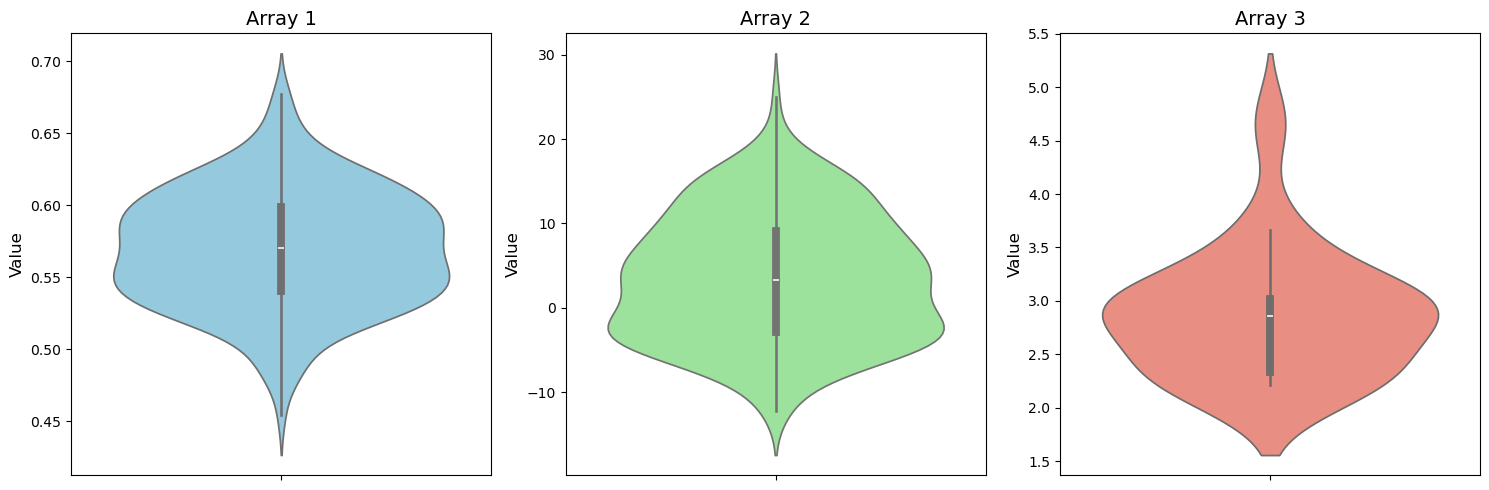

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# 创建一个包含三张子图的画布
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 绘制第一张小提琴图
sns.violinplot(y=cosine_similarity_per_seed, ax=axes[0], color='skyblue')
axes[0].set_title('Array 1', fontsize=14)
axes[0].set_ylabel('Value', fontsize=12)

# 绘制第二张小提琴图
sns.violinplot(y=ava_score_per_seed, ax=axes[1], color='lightgreen')
axes[1].set_title('Array 2', fontsize=14)
axes[1].set_ylabel('Value', fontsize=12)

# 绘制第三张小提琴图
sns.violinplot(y=vendi_score, ax=axes[2], color='salmon')
axes[2].set_title('Array 3', fontsize=14)
axes[2].set_ylabel('Value', fontsize=12)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [23]:
with open('cosine_similarity_per_seed.txt', 'w') as f:
    f.write(str(cosine_similarity_per_seed))
with open('ava_score_per_seed.txt', 'w') as f:
    f.write(str(ava_score_per_seed))
with open('vendi_score.txt', 'w') as f:
    f.write(str(vendi_score))

In [24]:
prompts = example_prompts.copy()
cosine_similarity_per_seed_aba = []
ava_score_per_seed_aba = []
vendi_score_aba = []
randomseeds = [1,2,5,7,10,100,42,88,99,73]
negative_prompt = ''
NUM_ITER=300
for prompt in example_prompts:
    label_a = NegativeLabel([example_prompts[prompt]],negative_prompt)
    labels = [label_a]
    weights = [1]
    image_of_this_prompt = []
    for seed in randomseeds:
        print(f"prompt {prompt},seed {seed}")
        ims = []
        torch.manual_seed(seed)
        np.random.seed(seed)
        img = learnable_image_maker()
        optim=torch.optim.SGD(img.parameters(),lr=1e-4)
        img_a = img
        learnable_images = [img_a]
        try:
            for iter_num in range(NUM_ITER):
                preds=[]
                for label,learnable_image,weight in rp.random_batch(list(zip(labels,learnable_images,weights)), batch_size=1):
                    
                    pred=s.train_step(
                        label.embedding,
                        learnable_image()[None],
                        noise_coef=.1*weight,guidance_scale=60
                    )
                    preds+=list(pred)
                optim.step()
                optim.zero_grad()
                with torch.no_grad():
                    if iter_num == NUM_ITER - 1:
                        im = rp.as_numpy_image(learnable_image())
                        ims.append(im)
                
        except KeyboardInterrupt:
            print('Interrupted early at iteration %i'%iter_num)
            im = img_a()
            ims.append(im)
            #rp.display_image(im)
            raise KeyboardInterrupt
        inputs1 = processor(images=tensor_to_pil(ims[-1]), return_tensors="pt", padding=True)
        with torch.no_grad():
            features1 = CLIP.get_image_features(**inputs1)
            features2 = CLIP.get_image_features(**inputs2)
        with torch.no_grad():
            cosine_similarity_per_seed_aba.append(torch.nn.functional.cosine_similarity(features1, features2).detach().cpu().numpy()[0])
            ava_score_per_seed_aba.append(AVA(features1).detach().cpu().numpy()[0,0])
        image_of_this_prompt.append(torch.tensor(ims[-1]).detach().permute(2,0,1))
        del ims
        del img
        torch.cuda.empty_cache()
        #rp.display_image(ims[-1])
    with torch.no_grad():
        vendi_score_aba.append(VendiScore(image_of_this_prompt))
    print(vendi_score_aba[-1])
    del image_of_this_prompt
    torch.cuda.empty_cache()
    

prompt colorful_sunset,seed 1
prompt colorful_sunset,seed 2
prompt colorful_sunset,seed 5
prompt colorful_sunset,seed 7
prompt colorful_sunset,seed 10
prompt colorful_sunset,seed 100
prompt colorful_sunset,seed 42
prompt colorful_sunset,seed 88
prompt colorful_sunset,seed 99
prompt colorful_sunset,seed 73
2.1493282
prompt abstract_shapes,seed 1
prompt abstract_shapes,seed 2
prompt abstract_shapes,seed 5
prompt abstract_shapes,seed 7
prompt abstract_shapes,seed 10
prompt abstract_shapes,seed 100
prompt abstract_shapes,seed 42
prompt abstract_shapes,seed 88
prompt abstract_shapes,seed 99
prompt abstract_shapes,seed 73
2.9048173
prompt futuristic_city,seed 1
prompt futuristic_city,seed 2
prompt futuristic_city,seed 5
prompt futuristic_city,seed 7
prompt futuristic_city,seed 10
prompt futuristic_city,seed 100
prompt futuristic_city,seed 42
prompt futuristic_city,seed 88
prompt futuristic_city,seed 99
prompt futuristic_city,seed 73
2.8344326
prompt dense_forest,seed 1
prompt dense_forest,se

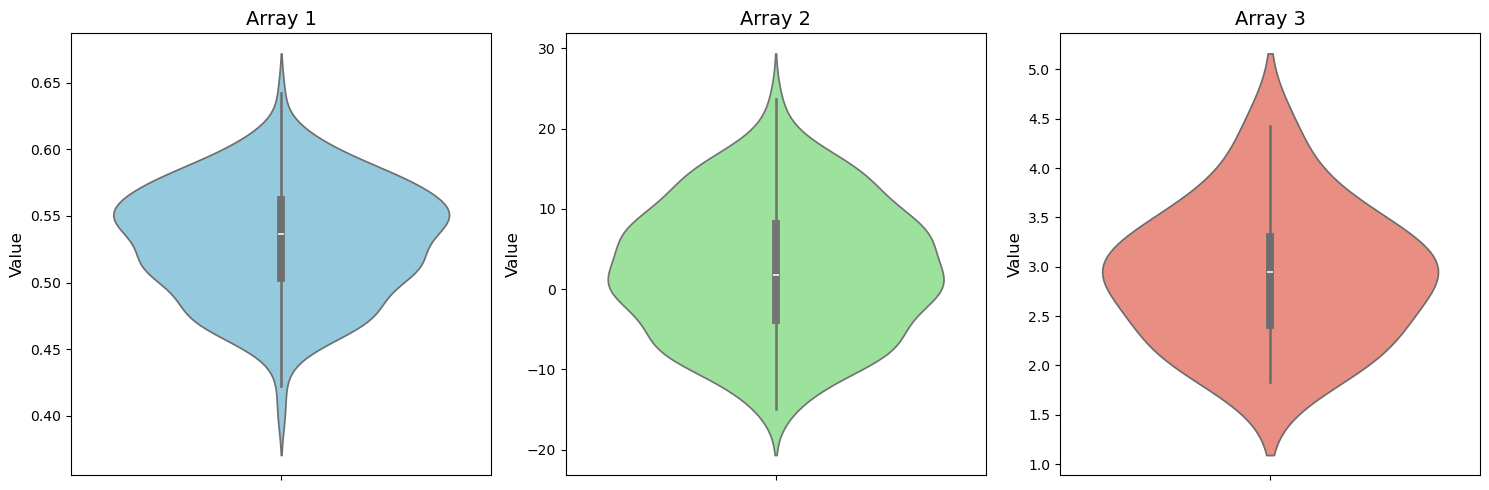

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# 创建一个包含三张子图的画布
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 绘制第一张小提琴图
sns.violinplot(y=cosine_similarity_per_seed_aba, ax=axes[0], color='skyblue')
axes[0].set_title('Array 1', fontsize=14)
axes[0].set_ylabel('Value', fontsize=12)

# 绘制第二张小提琴图
sns.violinplot(y=ava_score_per_seed_aba, ax=axes[1], color='lightgreen')
axes[1].set_title('Array 2', fontsize=14)
axes[1].set_ylabel('Value', fontsize=12)

# 绘制第三张小提琴图
sns.violinplot(y=vendi_score_aba, ax=axes[2], color='salmon')
axes[2].set_title('Array 3', fontsize=14)
axes[2].set_ylabel('Value', fontsize=12)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [26]:
with open('cosine_similarity_per_seed_aba.txt', 'w') as f:
    f.write(str(cosine_similarity_per_seed_aba))
with open('ava_score_per_seed_aba.txt', 'w') as f:
    f.write(str(ava_score_per_seed_aba))
with open('vendi_score_aba.txt', 'w') as f:
    f.write(str(vendi_score_aba))

/tmp/ipykernel_2529982/688614244.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='group', y='value', data=data, palette='pastel',  ax=ax,cut=0)
/tmp/ipykernel_2529982/688614244.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='group', y='value', data=data, palette='pastel',  ax=ax,cut=0)
/tmp/ipykernel_2529982/688614244.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='group', y='value', data=data, palette='pastel',  ax=ax,cut=0)


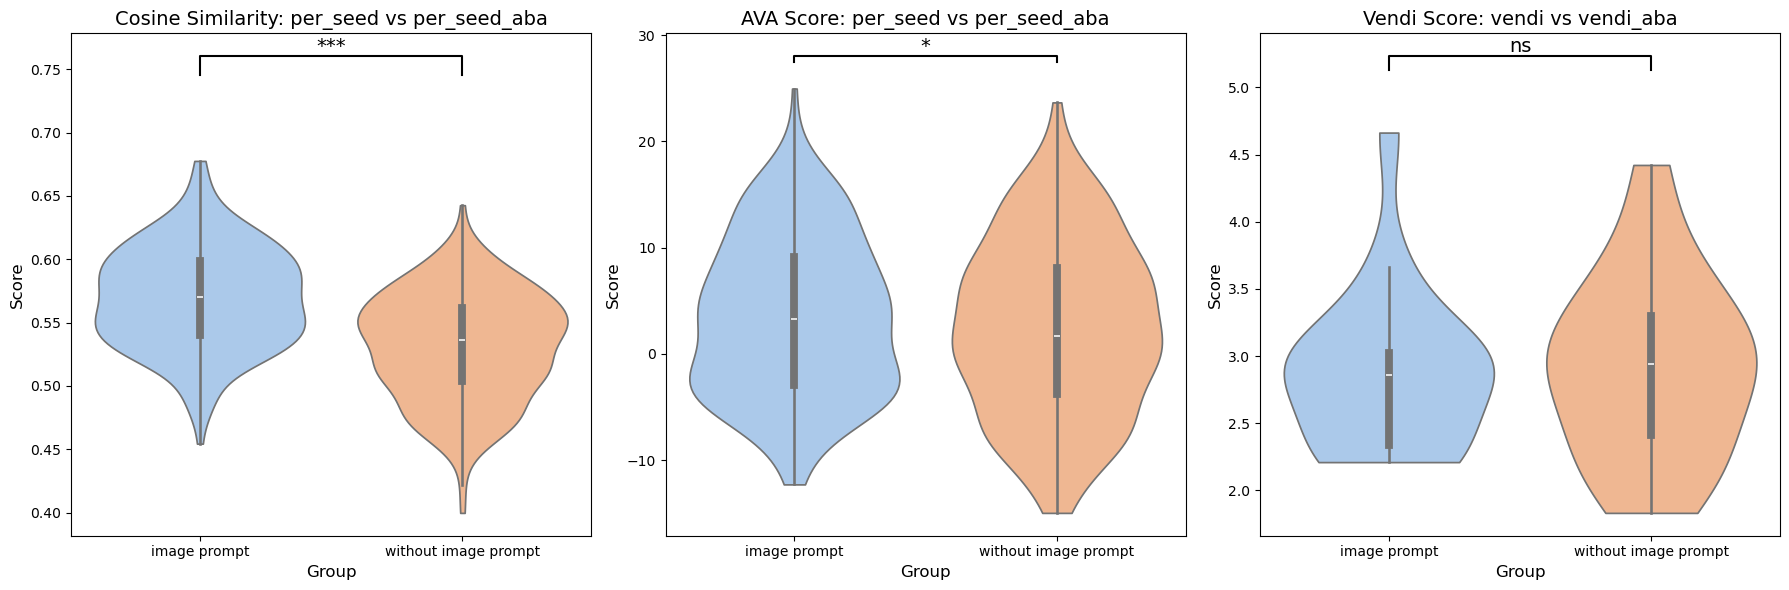

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# 定义函数：配对 t 检验并返回 p 值（单侧）
def paired_ttest_one_tailed(group1, group2, alternative='greater'):
    t_stat, p_value = stats.ttest_rel(group1, group2)
    if alternative == 'greater':
        if t_stat > 0:
            p_value_one_tailed = p_value / 2
        else:
            p_value_one_tailed = 1 - p_value / 2
    elif alternative == 'less':
        if t_stat < 0:
            p_value_one_tailed = p_value / 2
        else:
            p_value_one_tailed = 1 - p_value / 2
    else:
        p_value_one_tailed = p_value
    return p_value_one_tailed

# 定义函数：绘制小提琴图并标注显著性
def plot_violin_with_significance(ax, data, group1_name, group2_name, p_value, title):
    sns.violinplot(x='group', y='value', data=data, palette='pastel',  ax=ax,cut=0)
    p_value_one_tailed=p_value
    if p_value_one_tailed < 0.001:
        symbol = '***'
    elif p_value_one_tailed < 0.01:
        symbol = '**'
    elif p_value_one_tailed < 0.05:
        symbol = '*'
    else:
        symbol = 'ns'  # 不显著
    # 添加显著性标注
    x1, x2 = 0, 1  # 两组的位置
    y_max = max(data['value']) * 1.1  # 标注线的顶部位置
    h = 0.02 * y_max  # 标注线的高度
    ax.plot([x1, x1, x2, x2], [y_max, y_max + h, y_max + h, y_max], lw=1.5, c='k')  # 绘制标注线
    ax.text((x1 + x2) * 0.5, y_max + h, symbol, 
            ha='center', va='bottom', color='k', fontsize=14)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Group', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)

# 创建子图
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
p_value_cosine = paired_ttest_one_tailed(cosine_similarity_per_seed, cosine_similarity_per_seed_aba, alternative='greater')
data_cosine = pd.DataFrame({
    'value': np.concatenate([cosine_similarity_per_seed, cosine_similarity_per_seed_aba]),
    'group': ['image prompt'] * len(cosine_similarity_per_seed) + ['without image prompt'] * len(cosine_similarity_per_seed_aba)
})
plot_violin_with_significance(axes[0], data_cosine, 'per_seed', 'per_seed_aba', p_value_cosine, 'Cosine Similarity: per_seed vs per_seed_aba')
# 第一组：ava_score_per_seed vs ava_score_per_seed_aba
p_value_ava = paired_ttest_one_tailed(ava_score_per_seed, ava_score_per_seed_aba, alternative='greater')
data_ava = pd.DataFrame({
    'value': np.concatenate([ava_score_per_seed, ava_score_per_seed_aba]),
    'group': ['image prompt'] * len(ava_score_per_seed) + ['without image prompt'] * len(ava_score_per_seed_aba)
})
plot_violin_with_significance(axes[1], data_ava, 'per_seed', 'per_seed_aba', p_value_ava, 'AVA Score: per_seed vs per_seed_aba')

# 第二组：vendi_score vs vendi_score_aba
p_value_vendi = paired_ttest_one_tailed(vendi_score, vendi_score_aba, alternative='less')
data_vendi = pd.DataFrame({
    'value': np.concatenate([vendi_score, vendi_score_aba]),
    'group': ['image prompt'] * len(vendi_score) + ['without image prompt'] * len(vendi_score_aba)
})
plot_violin_with_significance(axes[2], data_vendi, 'vendi', 'vendi_aba', p_value_vendi, 'Vendi Score: vendi vs vendi_aba')

# 第三组：cosine_similarity_per_seed vs cosine_similarity_per_seed_aba


# 调整布局
plt.tight_layout()
plt.show()

In [57]:
np.save('cosine_similarity_per_seed.npy', cosine_similarity_per_seed)
np.save('ava_score_per_seed.npy', ava_score_per_seed)
np.save('vendi_score.npy', vendi_score)

np.save('cosine_similarity_per_seed_aba.npy', cosine_similarity_per_seed_aba)
np.save('ava_score_per_seed_aba.npy', ava_score_per_seed_aba)
np.save('vendi_score_aba.npy', vendi_score_aba)

In [ ]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

def extract_foreground_mask(image_tensor):
    # 使用PIL加载图像
    # image = Image.open(image_path).convert("RGB")

    # # 将图像转换为Tensor
    # transform = transforms.ToTensor()
    # image_tensor = transform(image).unsqueeze(0)  # 添加batch维度

    # 将Tensor转换回NumPy数组以便使用OpenCV
    image_np = image_tensor.squeeze(0).permute(1, 2, 0).numpy()  # 转换为HWC格式
    image_np = (image_np * 255).astype(np.uint8)  # 转换为0-255范围

    # 创建一个与图像大小相同的掩码
    mask = np.zeros(image_np.shape[:2], np.uint8)

    # 定义GrabCut算法使用的背景和前景模型
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # 定义矩形区域，包含前景对象
    height, width = image_np.shape[:2]
    rect = (int(width * 0.1), int(height * 0.1), int(width * 0.8), int(height * 0.8))

    # 应用GrabCut算法
    cv2.grabCut(image_np, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # 创建掩码，将确定的前景和可能的前景标记为1，其余为0
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # 将掩码转换为Tensor
    mask_tensor = torch.from_numpy(mask2).float()

    # 将掩码应用到图像上，提取前景
    foreground_tensor = image_tensor * mask_tensor.unsqueeze(0)  # 保持batch维度

    return mask_tensor, foreground_tensor

mask = extract_foreground_mask(image2)

In [ ]:
image=learnable_image_maker()
learnable_image_a=lambda: image() #Right-side up

optim=torch.optim.SGD(image.parameters(),lr=1e-4)
labels=[label_a]
learnable_images=[learnable_image_a]

#The weight coefficients for each prompt. For example, if we have [0,1], then only the upside-down mode will be optimized
weights=[1,1]

weights=rp.as_numpy_array(weights)
weights=weights/weights.sum()
weights=weights*len(weights)

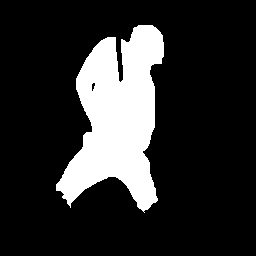

In [ ]:
mask = mask[0].unsqueeze(0).repeat(3, 1, 1)

In [ ]:
prompts = example_prompts.copy()
cosine_similarity_per_seed = []
ava_score_per_seed = []
vendi_score = []
randomseeds = [1,2,5,7,10,100,42,88,99,73]
negative_prompt = ''
NUM_ITER=300
for prompt in example_prompts:
    label_a = NegativeLabel([example_prompts[prompt]],negative_prompt)
    labels = [label_a]
    weights = [1]
    image_of_this_prompt = []
    for seed in randomseeds:
        print(f"prompt {prompt},seed {seed}")
        ims = []
        torch.manual_seed(seed)
        np.random.seed(seed)
        img = learnable_image_maker()
        optim=torch.optim.SGD(img.parameters(),lr=1e-4)
        img_a = img
        learnable_images = [img_a]
        try:
            for iter_num in range(NUM_ITER):
                preds=[]
                for label,learnable_image,weight in rp.random_batch(list(zip(labels,learnable_images,weights)), batch_size=1):
                    
                    pred=s.train_step(
                        label.embedding,
                        learnable_image()[None],
                        noise_coef=.1*weight,guidance_scale=60,target_image=image_tensor,mask=mask
                    )
                    preds+=list(pred)
                optim.step()
                optim.zero_grad()
                with torch.no_grad():
                    if iter_num == NUM_ITER - 1:
                        im = rp.as_numpy_image(learnable_image())
                        ims.append(im)
                
        except KeyboardInterrupt:
            print('Interrupted early at iteration %i'%iter_num)
            im = img_a()
            ims.append(im)
            #rp.display_image(im)
            raise KeyboardInterrupt
        inputs1 = processor(images=tensor_to_pil(ims[-1]), return_tensors="pt", padding=True)
        with torch.no_grad():
            features1 = CLIP.get_image_features(**inputs1)
            features2 = CLIP.get_image_features(**inputs2)
        with torch.no_grad():
            cosine_similarity_per_seed.append(torch.nn.functional.cosine_similarity(features1, features2).detach().cpu().numpy()[0])
            ava_score_per_seed.append(AVA(features1).detach().cpu().numpy()[0,0])
        image_of_this_prompt.append(torch.tensor(ims[-1]).detach().permute(2,0,1))
        del ims
        del img
        torch.cuda.empty_cache()
        #rp.display_image(ims[-1])
    with torch.no_grad():
        vendi_score.append(VendiScore(image_of_this_prompt))
    print(vendi_score[-1])
    del image_of_this_prompt
    torch.cuda.empty_cache()

    

prompt colorful_sunset,seed 1
prompt colorful_sunset,seed 2
prompt colorful_sunset,seed 5
prompt colorful_sunset,seed 7
prompt colorful_sunset,seed 10
prompt colorful_sunset,seed 100
prompt colorful_sunset,seed 42
prompt colorful_sunset,seed 88
prompt colorful_sunset,seed 99
prompt colorful_sunset,seed 73
2.995907
prompt abstract_shapes,seed 1
prompt abstract_shapes,seed 2
prompt abstract_shapes,seed 5
prompt abstract_shapes,seed 7
prompt abstract_shapes,seed 10
prompt abstract_shapes,seed 100
prompt abstract_shapes,seed 42
prompt abstract_shapes,seed 88
prompt abstract_shapes,seed 99
prompt abstract_shapes,seed 73
2.8501377
prompt futuristic_city,seed 1
prompt futuristic_city,seed 2
prompt futuristic_city,seed 5
prompt futuristic_city,seed 7
prompt futuristic_city,seed 10
prompt futuristic_city,seed 100
prompt futuristic_city,seed 42
prompt futuristic_city,seed 88
prompt futuristic_city,seed 99
prompt futuristic_city,seed 73
2.846014
prompt dense_forest,seed 1
prompt dense_forest,seed

In [ ]:
np.save('cosine_similarity_per_seed_mask.npy', cosine_similarity_per_seed)
np.save('ava_score_per_seed_mask.npy', ava_score_per_seed)
np.save('vendi_score_mask.npy', vendi_score)